# Week 5.1: Linear Regression Models for Quantitative Finance

---

## Overview

Linear regression is the cornerstone of quantitative finance and forms the foundation for:
- **Factor Models**: CAPM, Fama-French, APT
- **Return Prediction**: Cross-sectional and time-series forecasting
- **Risk Decomposition**: Attribution analysis
- **Portfolio Construction**: Optimal weight estimation

This week covers:
| Day | Topic | Key Concepts |
|-----|-------|-------------|
| 1 | OLS Regression | Assumptions, MLE, Statistical Inference |
| 2 | Ridge Regression | L2 Regularization, Bias-Variance Tradeoff |
| 3 | Lasso Regression | L1 Regularization, Feature Selection |
| 4 | Elastic Net | Combined Regularization, Grouped Selection |
| 5 | Fama-MacBeth | Cross-Sectional Regression, Risk Premia |
| 6 | WLS & Robust | Heteroskedasticity, Outlier Resistance |
| 7 | Interview Review | Key Questions & Applications |

---

In [1]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
warnings.filterwarnings('ignore')

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Download Financial Data
# We'll use a diversified set of assets for our examples

tickers = ['SPY', 'QQQ', 'IWM', 'EFA', 'TLT', 'GLD', 'VNQ', 'XLF', 'XLE', 'XLK']
start_date = '2018-01-01'
end_date = '2024-01-01'

# Download adjusted close prices (yfinance auto_adjust=True returns 'Close')
prices = yf.download(tickers, start=start_date, end=end_date)['Close']
returns = prices.pct_change().dropna()

# Download Fama-French factors proxy (using ETFs)
ff_tickers = ['SPY', 'IWM', 'IWD', 'IWF']  # Market, Small Cap, Value, Growth
ff_prices = yf.download(ff_tickers, start=start_date, end=end_date)['Close']
ff_returns = ff_prices.pct_change().dropna()

print(f"Data downloaded: {len(returns)} trading days")
print(f"Date range: {returns.index[0].strftime('%Y-%m-%d')} to {returns.index[-1].strftime('%Y-%m-%d')}")
returns.head()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  4 of 4 completed

Data downloaded: 1508 trading days
Date range: 2018-01-03 to 2023-12-29


Ticker,EFA,GLD,IWM,QQQ,SPY,TLT,VNQ,XLE,XLF,XLK
Date,,,,,,,,,,
2018-01-03,0.004800,-0.002637,0.001039,0.009717,0.006325,0.004781,-0.002903,0.014976,0.005372,0.008341
2018-01-04,0.010960,0.005127,0.002661,0.001750,0.004215,-0.000159,-0.017227,0.006036,0.009263,0.005055
2018-01-05,0.005559,-0.001036,0.002072,0.010043,0.006664,-0.002855,0.000494,-0.000400,0.002824,0.010517
2018-01-08,-0.000276,-0.000160,0.001551,0.003891,0.001829,-0.000636,0.005182,0.006002,-0.001408,0.003771
2018-01-09,0.001106,-0.004628,-0.001355,0.000062,0.002263,-0.013373,-0.012888,-0.002519,0.007754,-0.002554


---

# Day 1: Ordinary Least Squares (OLS) Regression

## 1.1 The Linear Regression Model

The fundamental linear regression model assumes:

$$Y = X\beta + \epsilon$$

Where:
- $Y \in \mathbb{R}^{n}$: Vector of dependent variable observations
- $X \in \mathbb{R}^{n \times p}$: Design matrix of independent variables
- $\beta \in \mathbb{R}^{p}$: Vector of coefficients to estimate
- $\epsilon \in \mathbb{R}^{n}$: Vector of error terms

### In Finance: The CAPM Example

The Capital Asset Pricing Model is a single-factor regression:

$$R_i - R_f = \alpha_i + \beta_i(R_m - R_f) + \epsilon_i$$

Where:
- $R_i - R_f$: Excess return of asset $i$
- $\alpha_i$: Jensen's alpha (risk-adjusted excess return)
- $\beta_i$: Market beta (systematic risk exposure)
- $R_m - R_f$: Market risk premium

---

## 1.2 OLS Estimator Derivation

### Objective Function

OLS minimizes the sum of squared residuals:

$$\hat{\beta}_{OLS} = \arg\min_{\beta} \sum_{i=1}^{n} (y_i - x_i'\beta)^2 = \arg\min_{\beta} ||Y - X\beta||_2^2$$

### Closed-Form Solution

Taking the derivative and setting to zero:

$$\frac{\partial}{\partial \beta} (Y - X\beta)'(Y - X\beta) = -2X'Y + 2X'X\beta = 0$$

Solving for $\beta$:

$$\boxed{\hat{\beta}_{OLS} = (X'X)^{-1}X'Y}$$

This is the **Normal Equation** - the most important formula in regression analysis.

---

## 1.3 Gauss-Markov Assumptions

For OLS to be the **Best Linear Unbiased Estimator (BLUE)**, we need:

| Assumption | Mathematical Form | Financial Implication |
|------------|-------------------|----------------------|
| **Linearity** | $E[Y|X] = X\beta$ | Returns are linear in factors |
| **No Perfect Multicollinearity** | $\text{rank}(X) = p$ | Factors are not redundant |
| **Exogeneity** | $E[\epsilon|X] = 0$ | No omitted variables, no simultaneity |
| **Homoskedasticity** | $\text{Var}(\epsilon|X) = \sigma^2 I$ | Constant volatility (rarely true!) |
| **No Autocorrelation** | $\text{Cov}(\epsilon_i, \epsilon_j) = 0$ for $i \neq j$ | No serial correlation in residuals |

### Why These Matter in Finance

1. **Homoskedasticity Violation**: Volatility clustering → Use WLS or GARCH
2. **Autocorrelation Violation**: Momentum/mean-reversion → Use Newey-West standard errors
3. **Exogeneity Violation**: Endogenous regressors → Use instrumental variables

---

In [3]:
# Day 1: OLS Implementation - CAPM Beta Estimation

# Prepare data for CAPM regression
# Using SPY as market proxy, XLK (Tech) as the asset
market_returns = returns['SPY'].values
asset_returns = returns['XLK'].values

# Method 1: Manual OLS using Normal Equation
def ols_manual(X, y):
    """
    Implement OLS using the normal equation: β = (X'X)^(-1)X'y
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
    y : array-like, shape (n_samples,)
    
    Returns:
    --------
    beta : array, OLS coefficients
    """
    X = np.column_stack([np.ones(len(X)), X])  # Add intercept
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta

# Estimate CAPM beta manually
beta_manual = ols_manual(market_returns, asset_returns)
print("=" * 60)
print("CAPM REGRESSION: XLK ~ SPY")
print("=" * 60)
print(f"\nManual OLS Results:")
print(f"  Alpha (Intercept): {beta_manual[0]:.6f} ({beta_manual[0]*252:.4f} annualized)")
print(f"  Beta (Market):     {beta_manual[1]:.4f}")

CAPM REGRESSION: XLK ~ SPY

Manual OLS Results:
  Alpha (Intercept): 0.000259 (0.0652 annualized)
  Beta (Market):     1.2316


In [4]:
# Method 2: Using statsmodels for full statistical inference
X_sm = sm.add_constant(market_returns)
model_ols = sm.OLS(asset_returns, X_sm).fit()

print("\n" + "=" * 60)
print("STATSMODELS OLS SUMMARY")
print("=" * 60)
print(model_ols.summary())


STATSMODELS OLS SUMMARY
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 1.130e+04
Date:                Sat, 24 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:41:03   Log-Likelihood:                 5633.2
No. Observations:                1508   AIC:                        -1.126e+04
Df Residuals:                    1506   BIC:                        -1.125e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      

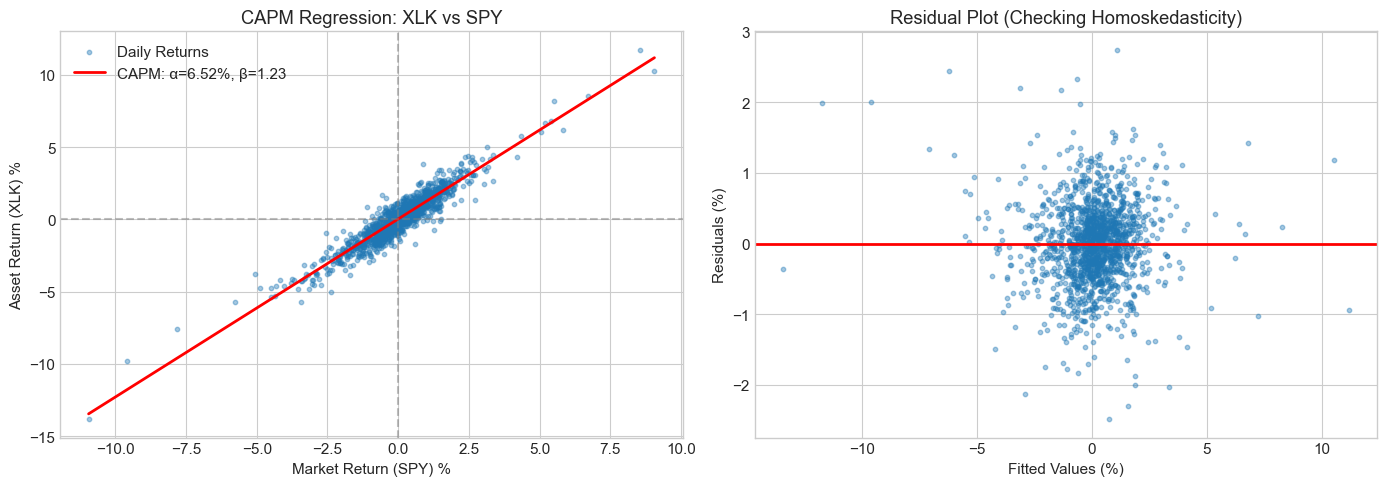

In [5]:
# Visualize the CAPM Regression
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter plot with regression line
ax1 = axes[0]
ax1.scatter(market_returns * 100, asset_returns * 100, alpha=0.4, s=10, label='Daily Returns')
x_line = np.linspace(market_returns.min(), market_returns.max(), 100)
y_line = beta_manual[0] + beta_manual[1] * x_line
ax1.plot(x_line * 100, y_line * 100, 'r-', linewidth=2, 
         label=f'CAPM: α={beta_manual[0]*252:.2%}, β={beta_manual[1]:.2f}')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Market Return (SPY) %')
ax1.set_ylabel('Asset Return (XLK) %')
ax1.set_title('CAPM Regression: XLK vs SPY')
ax1.legend()

# Plot 2: Residual diagnostics
residuals = asset_returns - (beta_manual[0] + beta_manual[1] * market_returns)
ax2 = axes[1]
ax2.scatter(model_ols.fittedvalues * 100, residuals * 100, alpha=0.4, s=10)
ax2.axhline(y=0, color='r', linestyle='-', linewidth=2)
ax2.set_xlabel('Fitted Values (%)')
ax2.set_ylabel('Residuals (%)')
ax2.set_title('Residual Plot (Checking Homoskedasticity)')

plt.tight_layout()
plt.show()

In [6]:
# Test OLS Assumptions
print("=" * 60)
print("OLS ASSUMPTION TESTS")
print("=" * 60)

# 1. Normality Test (Jarque-Bera)
jb_stat, jb_pvalue = stats.jarque_bera(residuals)
print(f"\n1. Normality Test (Jarque-Bera):")
print(f"   Statistic: {jb_stat:.2f}, p-value: {jb_pvalue:.4f}")
print(f"   Result: {'Residuals are normal' if jb_pvalue > 0.05 else 'Residuals NOT normal (common in finance)'}")

# 2. Homoskedasticity Test (Breusch-Pagan)
from statsmodels.stats.diagnostic import het_breuschpagan
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, X_sm)
print(f"\n2. Homoskedasticity Test (Breusch-Pagan):")
print(f"   Statistic: {bp_stat:.2f}, p-value: {bp_pvalue:.4f}")
print(f"   Result: {'Homoskedastic' if bp_pvalue > 0.05 else 'Heteroskedastic - consider WLS/robust SE'}")

# 3. Autocorrelation Test (Durbin-Watson)
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"\n3. Autocorrelation Test (Durbin-Watson):")
print(f"   Statistic: {dw_stat:.2f} (ideal = 2.0)")
print(f"   Result: {'No autocorrelation' if 1.5 < dw_stat < 2.5 else 'Possible autocorrelation'}")

# 4. VIF for multicollinearity (if multiple regressors)
print(f"\n4. Model Statistics:")
print(f"   R-squared: {model_ols.rsquared:.4f}")
print(f"   Adjusted R-squared: {model_ols.rsquared_adj:.4f}")
print(f"   F-statistic: {model_ols.fvalue:.2f} (p-value: {model_ols.f_pvalue:.2e})")

OLS ASSUMPTION TESTS

1. Normality Test (Jarque-Bera):
   Statistic: 172.93, p-value: 0.0000
   Result: Residuals NOT normal (common in finance)

2. Homoskedasticity Test (Breusch-Pagan):
   Statistic: 7.29, p-value: 0.0069
   Result: Heteroskedastic - consider WLS/robust SE

3. Autocorrelation Test (Durbin-Watson):
   Statistic: 1.94 (ideal = 2.0)
   Result: No autocorrelation

4. Model Statistics:
   R-squared: 0.8824
   Adjusted R-squared: 0.8823
   F-statistic: 11296.84 (p-value: 0.00e+00)


---

# Day 2: Ridge Regression (L2 Regularization)

## 2.1 The Bias-Variance Tradeoff

OLS is **unbiased** but can have **high variance** when:
- Features are highly correlated (multicollinearity)
- Number of features is large relative to observations
- Model is overfitting to noise

The expected prediction error decomposes as:

$$E[(y - \hat{f}(x))^2] = \underbrace{\text{Bias}^2[\hat{f}(x)]}_{\text{Error from simplification}} + \underbrace{\text{Var}[\hat{f}(x)]}_{\text{Error from estimation}} + \underbrace{\sigma^2_{\epsilon}}_{\text{Irreducible noise}}$$

**Ridge regression introduces bias to reduce variance**, potentially lowering overall prediction error.

---

## 2.2 Ridge Regression Formulation

Ridge adds an **L2 penalty** on coefficient magnitudes:

$$\hat{\beta}_{Ridge} = \arg\min_{\beta} \left\{ \sum_{i=1}^{n} (y_i - x_i'\beta)^2 + \lambda \sum_{j=1}^{p} \beta_j^2 \right\}$$

Or equivalently:

$$\hat{\beta}_{Ridge} = \arg\min_{\beta} ||Y - X\beta||_2^2 + \lambda ||\beta||_2^2$$

### Closed-Form Solution

$$\boxed{\hat{\beta}_{Ridge} = (X'X + \lambda I)^{-1}X'Y}$$

**Key insight**: Adding $\lambda I$ to $X'X$ ensures invertibility even when $X'X$ is singular!

---

## 2.3 Properties of Ridge Regression

### Shrinkage Behavior

Using SVD decomposition $X = UDV'$, the Ridge solution can be written as:

$$\hat{\beta}_{Ridge} = \sum_{j=1}^{p} \frac{d_j^2}{d_j^2 + \lambda} \cdot \frac{u_j'y}{d_j} \cdot v_j$$

Where:
- $d_j$: Singular values of $X$
- $\frac{d_j^2}{d_j^2 + \lambda}$: Shrinkage factor (0 to 1)

**Coefficients associated with small singular values are shrunk more heavily.**

### Financial Application

In multi-factor models, Ridge helps when:
- Factors are correlated (e.g., Value and Quality overlap)
- Estimating time-varying betas with limited data
- Preventing extreme factor exposures in portfolio construction

---

In [7]:
# Day 2: Ridge Regression Implementation

# Create multi-factor model features
# Using multiple ETFs as factor proxies
factor_tickers = ['SPY', 'IWM', 'TLT', 'GLD', 'VNQ']
target_ticker = 'XLF'  # Financial sector

X_factors = returns[factor_tickers].values
y_target = returns[target_ticker].values

# Standardize features (important for regularization!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_factors)

print("Multi-Factor Model Setup:")
print(f"Target: {target_ticker}")
print(f"Factors: {factor_tickers}")
print(f"Observations: {len(y_target)}")

Multi-Factor Model Setup:
Target: XLF
Factors: ['SPY', 'IWM', 'TLT', 'GLD', 'VNQ']
Observations: 1508


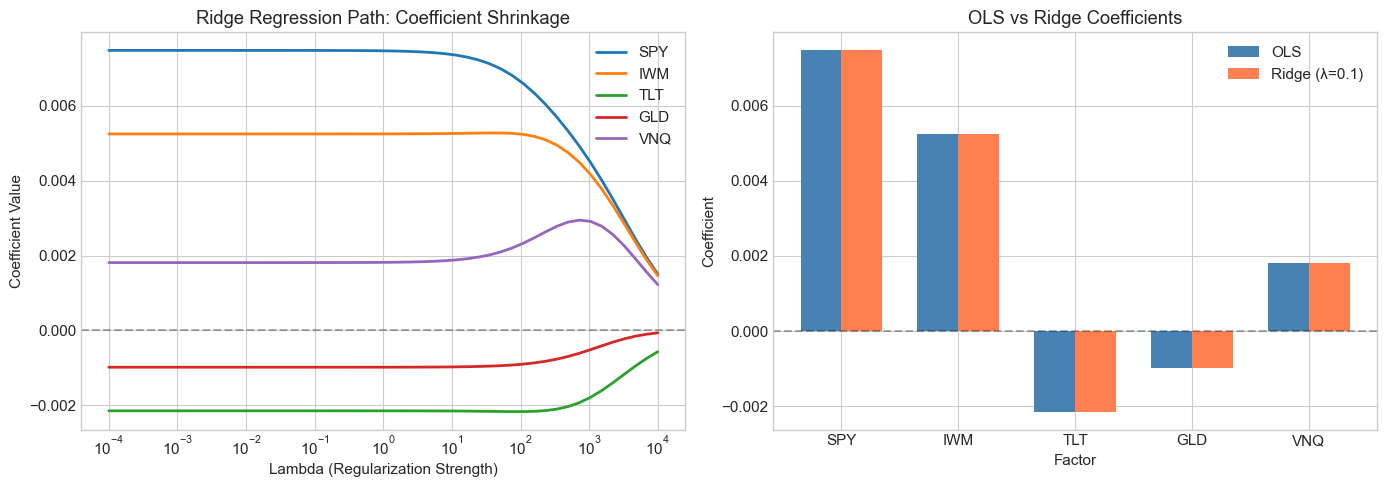

In [8]:
# Compare OLS vs Ridge across different lambda values
lambdas = np.logspace(-4, 4, 50)
ridge_coefs = []

# OLS coefficients (lambda = 0)
ols_model = LinearRegression()
ols_model.fit(X_scaled, y_target)
ols_coefs = ols_model.coef_

# Ridge coefficients for each lambda
for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_scaled, y_target)
    ridge_coefs.append(ridge.coef_)

ridge_coefs = np.array(ridge_coefs)

# Plot Ridge Path (coefficient shrinkage)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Ridge coefficient paths
ax1 = axes[0]
for i, factor in enumerate(factor_tickers):
    ax1.semilogx(lambdas, ridge_coefs[:, i], label=factor, linewidth=2)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax1.set_xlabel('Lambda (Regularization Strength)')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Ridge Regression Path: Coefficient Shrinkage')
ax1.legend(loc='upper right')

# Plot 2: Coefficient comparison at specific lambda
optimal_lambda = 0.1
ridge_optimal = Ridge(alpha=optimal_lambda)
ridge_optimal.fit(X_scaled, y_target)

ax2 = axes[1]
x_pos = np.arange(len(factor_tickers))
width = 0.35
bars1 = ax2.bar(x_pos - width/2, ols_coefs, width, label='OLS', color='steelblue')
bars2 = ax2.bar(x_pos + width/2, ridge_optimal.coef_, width, label=f'Ridge (λ={optimal_lambda})', color='coral')
ax2.set_xlabel('Factor')
ax2.set_ylabel('Coefficient')
ax2.set_title(f'OLS vs Ridge Coefficients')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(factor_tickers)
ax2.legend()
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

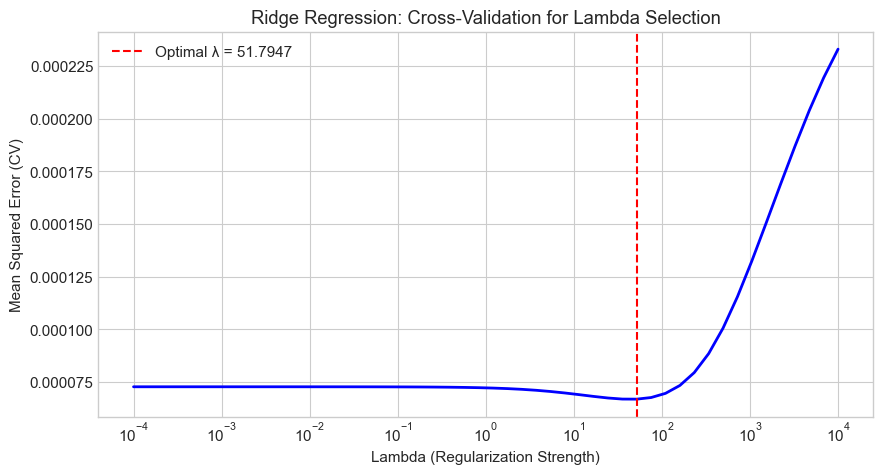


Optimal Lambda (Time Series CV): 51.794747


In [9]:
# Cross-validation for optimal lambda selection
from sklearn.linear_model import RidgeCV

# Time Series Cross-Validation (important for financial data!)
tscv = TimeSeriesSplit(n_splits=5)

# Ridge CV with time series splits
ridge_cv_scores = []
for lam in lambdas:
    ridge = Ridge(alpha=lam)
    scores = cross_val_score(ridge, X_scaled, y_target, cv=tscv, scoring='neg_mean_squared_error')
    ridge_cv_scores.append(-scores.mean())

optimal_idx = np.argmin(ridge_cv_scores)
optimal_lambda_cv = lambdas[optimal_idx]

# Plot CV results
plt.figure(figsize=(10, 5))
plt.semilogx(lambdas, ridge_cv_scores, 'b-', linewidth=2)
plt.axvline(x=optimal_lambda_cv, color='r', linestyle='--', 
            label=f'Optimal λ = {optimal_lambda_cv:.4f}')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Mean Squared Error (CV)')
plt.title('Ridge Regression: Cross-Validation for Lambda Selection')
plt.legend()
plt.show()

print(f"\nOptimal Lambda (Time Series CV): {optimal_lambda_cv:.6f}")

---

# Day 3: Lasso Regression (L1 Regularization)

## 3.1 Lasso Formulation

LASSO (Least Absolute Shrinkage and Selection Operator) uses an **L1 penalty**:

$$\hat{\beta}_{Lasso} = \arg\min_{\beta} \left\{ \frac{1}{2n} \sum_{i=1}^{n} (y_i - x_i'\beta)^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right\}$$

Or equivalently:

$$\hat{\beta}_{Lasso} = \arg\min_{\beta} \frac{1}{2n}||Y - X\beta||_2^2 + \lambda ||\beta||_1$$

### Key Difference from Ridge

| Property | Ridge (L2) | Lasso (L1) |
|----------|-----------|------------|
| Penalty | $\lambda\sum\beta_j^2$ | $\lambda\sum|\beta_j|$ |
| Solution | Closed-form | Requires optimization |
| Sparsity | Shrinks toward zero | **Sets coefficients exactly to zero** |
| Feature Selection | No | **Yes** |
| Correlated features | Keeps all | Tends to pick one |

---

## 3.2 Why L1 Induces Sparsity

### Geometric Intuition

The constraint regions have different shapes:
- **Ridge**: $||\beta||_2 \leq t$ is a **sphere** (smooth, no corners)
- **Lasso**: $||\beta||_1 \leq t$ is a **diamond** (corners at axes)

The OLS solution contours are ellipses. With Lasso, these contours are more likely to intersect the constraint region at a corner, where some coordinates are exactly zero.

### Soft Thresholding

For orthonormal $X$, Lasso has a closed-form solution:

$$\hat{\beta}_j^{Lasso} = \text{sign}(\hat{\beta}_j^{OLS}) \cdot \max(|\hat{\beta}_j^{OLS}| - \lambda, 0)$$

This is the **soft-thresholding operator** - coefficients smaller than $\lambda$ become exactly zero.

---

## 3.3 Financial Applications of Lasso

1. **Factor Selection**: Which factors actually contribute to returns?
2. **Sparse Portfolios**: Limit number of holdings
3. **Signal Selection**: Identify relevant predictive signals from many candidates
4. **High-Dimensional Regression**: When $p > n$ (more features than observations)

---

In [10]:
# Day 3: Lasso Regression Implementation

# Create a high-dimensional factor model
# Using all available ETFs plus lagged returns
all_factor_tickers = ['SPY', 'QQQ', 'IWM', 'EFA', 'TLT', 'GLD', 'VNQ']
target = 'XLK'

# Create feature matrix with current and lagged returns
feature_df = returns[all_factor_tickers].copy()

# Add lagged features (1-5 days)
for lag in range(1, 6):
    for ticker in all_factor_tickers:
        feature_df[f'{ticker}_lag{lag}'] = returns[ticker].shift(lag)

# Add rolling volatility features
for ticker in all_factor_tickers:
    feature_df[f'{ticker}_vol20'] = returns[ticker].rolling(20).std()

# Prepare data
feature_df = feature_df.dropna()
y_lasso = returns.loc[feature_df.index, target].values
X_lasso = feature_df.values
feature_names = feature_df.columns.tolist()

# Standardize
scaler_lasso = StandardScaler()
X_lasso_scaled = scaler_lasso.fit_transform(X_lasso)

print(f"Feature Matrix Shape: {X_lasso.shape}")
print(f"Number of Features: {len(feature_names)}")
print(f"\nFeature Categories:")
print(f"  - Current returns: {len(all_factor_tickers)}")
print(f"  - Lagged returns: {len(all_factor_tickers) * 5}")
print(f"  - Volatility features: {len(all_factor_tickers)}")

Feature Matrix Shape: (1489, 49)
Number of Features: 49

Feature Categories:
  - Current returns: 7
  - Lagged returns: 35
  - Volatility features: 7


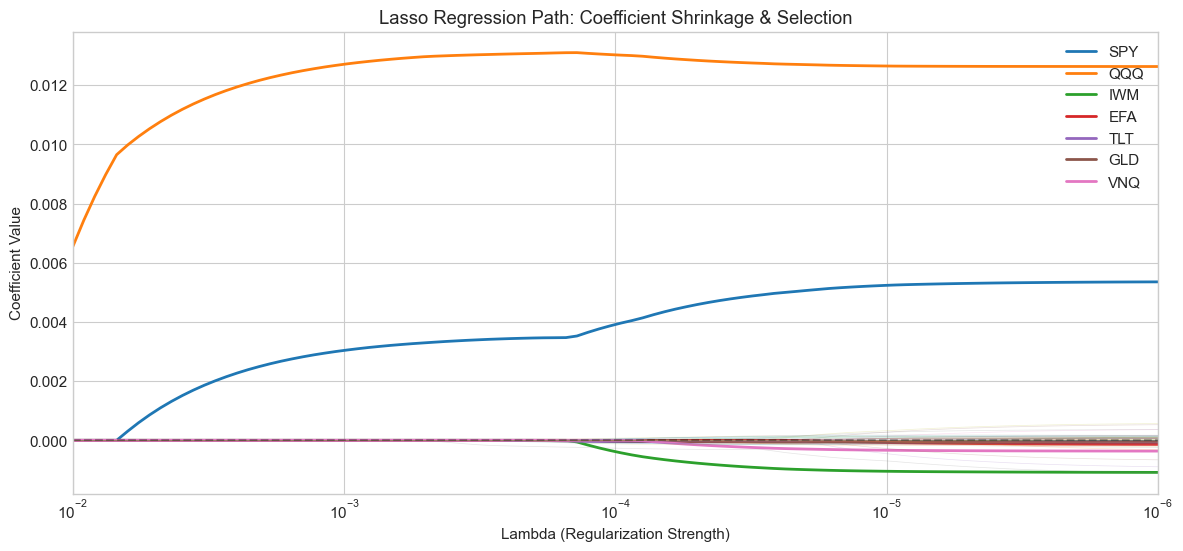

In [11]:
# Lasso Path - see which features get selected at different lambda values
from sklearn.linear_model import lasso_path

# Compute Lasso path
alphas_lasso, coefs_lasso, _ = lasso_path(X_lasso_scaled, y_lasso, alphas=np.logspace(-6, -2, 100))

# Plot Lasso Path
plt.figure(figsize=(14, 6))
for i, name in enumerate(feature_names):
    if 'lag' not in name and 'vol' not in name:  # Only plot current returns for clarity
        plt.semilogx(alphas_lasso, coefs_lasso[i, :], label=name, linewidth=2)
    else:
        plt.semilogx(alphas_lasso, coefs_lasso[i, :], alpha=0.2, linewidth=0.5)

plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regression Path: Coefficient Shrinkage & Selection')
plt.legend(loc='upper right')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xlim(alphas_lasso.max(), alphas_lasso.min())
plt.show()

In [12]:
# Find optimal Lasso lambda using Cross-Validation
from sklearn.linear_model import LassoCV

# Lasso with Time Series CV
tscv = TimeSeriesSplit(n_splits=5)
lasso_cv = LassoCV(alphas=np.logspace(-6, -2, 100), cv=tscv, max_iter=10000)
lasso_cv.fit(X_lasso_scaled, y_lasso)

print("=" * 60)
print("LASSO REGRESSION RESULTS")
print("=" * 60)
print(f"\nOptimal Lambda: {lasso_cv.alpha_:.6f}")
print(f"\nSelected Features ({np.sum(lasso_cv.coef_ != 0)} of {len(feature_names)}):")

# Show non-zero coefficients
selected_features = [(name, coef) for name, coef in zip(feature_names, lasso_cv.coef_) if coef != 0]
selected_features.sort(key=lambda x: abs(x[1]), reverse=True)

print("\n{:<20} {:>15}".format("Feature", "Coefficient"))
print("-" * 35)
for name, coef in selected_features[:15]:  # Top 15
    print(f"{name:<20} {coef:>15.6f}")

LASSO REGRESSION RESULTS

Optimal Lambda: 0.000072

Selected Features (21 of 49):

Feature                  Coefficient
-----------------------------------
QQQ                         0.012928
SPY                         0.004282
IWM                        -0.000614
SPY_lag1                   -0.000288
SPY_lag4                   -0.000133
EFA_lag1                   -0.000113
TLT_lag2                    0.000095
VNQ_lag2                   -0.000089
GLD_lag5                    0.000074
TLT_lag3                    0.000073
TLT_lag5                    0.000073
VNQ                        -0.000056
TLT                        -0.000044
GLD                        -0.000038
SPY_lag2                   -0.000034


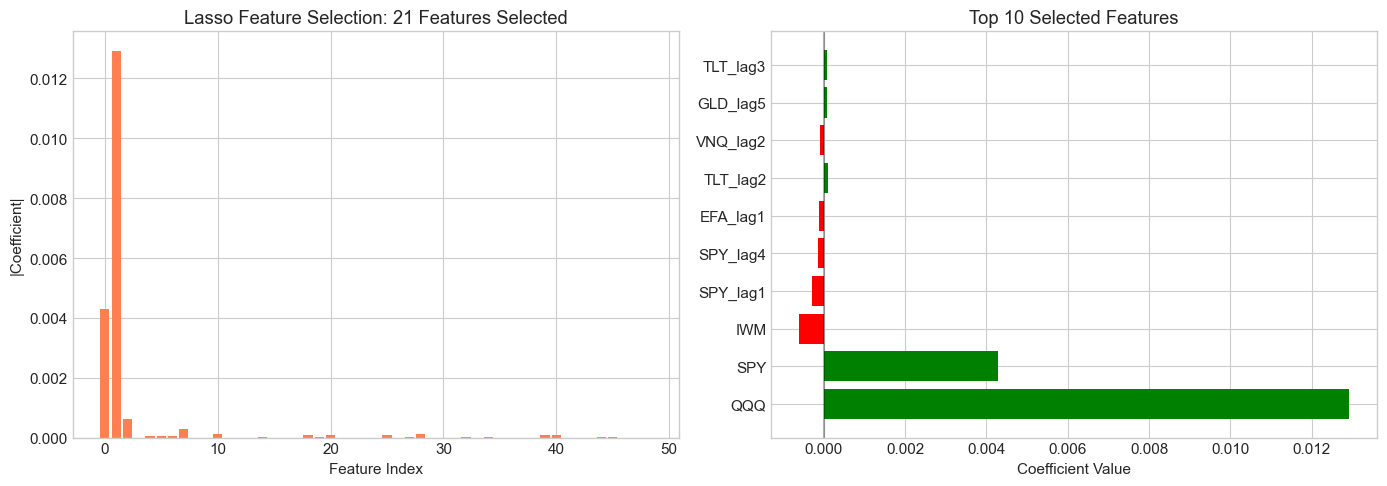

In [13]:
# Visualize feature importance from Lasso
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: All coefficients (many are zero)
ax1 = axes[0]
colors = ['coral' if c != 0 else 'lightgray' for c in lasso_cv.coef_]
ax1.bar(range(len(lasso_cv.coef_)), np.abs(lasso_cv.coef_), color=colors)
ax1.set_xlabel('Feature Index')
ax1.set_ylabel('|Coefficient|')
ax1.set_title(f'Lasso Feature Selection: {np.sum(lasso_cv.coef_ != 0)} Features Selected')

# Plot 2: Top selected features
ax2 = axes[1]
if selected_features:
    names, coefs = zip(*selected_features[:10])
    colors = ['green' if c > 0 else 'red' for c in coefs]
    ax2.barh(range(len(names)), coefs, color=colors)
    ax2.set_yticks(range(len(names)))
    ax2.set_yticklabels(names)
    ax2.set_xlabel('Coefficient Value')
    ax2.set_title('Top 10 Selected Features')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

---

# Day 4: Elastic Net (Combined L1 + L2)

## 4.1 Elastic Net Formulation

Elastic Net combines both L1 and L2 penalties:

$$\hat{\beta}_{EN} = \arg\min_{\beta} \left\{ \frac{1}{2n}||Y - X\beta||_2^2 + \lambda \left[ \frac{1-\alpha}{2}||\beta||_2^2 + \alpha||\beta||_1 \right] \right\}$$

Where:
- $\lambda$: Overall regularization strength
- $\alpha \in [0, 1]$: Mixing parameter
  - $\alpha = 0$: Pure Ridge
  - $\alpha = 1$: Pure Lasso
  - $\alpha = 0.5$: Equal mix

---

## 4.2 Advantages of Elastic Net

### Grouped Selection

When features are highly correlated:
- **Lasso**: Tends to select one feature arbitrarily, ignoring others
- **Elastic Net**: Tends to select/deselect correlated features together

### Example in Finance

Consider correlated factors like:
- `MSCI_Value` and `FF_HML` (both measure value)
- `MSCI_Momentum` and `FF_UMD` (both measure momentum)

Elastic Net will either include both or exclude both, providing more stable factor selection.

### Mathematical Intuition

For two perfectly correlated features $x_1 = x_2$:
- **Lasso solution**: $\beta_1 + \beta_2 = c$ (infinite solutions along a line)
- **Elastic Net solution**: $\beta_1 = \beta_2 = c/2$ (unique solution due to L2)

---

## 4.3 When to Use Each Method

| Scenario | Recommended Method |
|----------|-------------------|
| Few features, no multicollinearity | OLS |
| Many correlated features, keep all | Ridge |
| Many features, need sparsity | Lasso |
| Correlated features, need sparsity | **Elastic Net** |
| $p >> n$ (more features than samples) | Elastic Net or Lasso |

---

In [14]:
# Day 4: Elastic Net Implementation

from sklearn.linear_model import ElasticNetCV

# Test different alpha values (L1 ratio)
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]

elastic_results = []
for l1_ratio in l1_ratios:
    en_cv = ElasticNetCV(
        l1_ratio=l1_ratio, 
        alphas=np.logspace(-6, -2, 50),
        cv=TimeSeriesSplit(n_splits=5),
        max_iter=10000
    )
    en_cv.fit(X_lasso_scaled, y_lasso)
    
    # Calculate metrics
    predictions = en_cv.predict(X_lasso_scaled)
    mse = mean_squared_error(y_lasso, predictions)
    n_selected = np.sum(en_cv.coef_ != 0)
    
    elastic_results.append({
        'l1_ratio': l1_ratio,
        'alpha': en_cv.alpha_,
        'mse': mse,
        'n_features': n_selected,
        'coef': en_cv.coef_.copy()
    })

# Display results
results_df = pd.DataFrame(elastic_results)
print("=" * 70)
print("ELASTIC NET: VARYING L1 RATIO")
print("=" * 70)
print(f"\n{'L1 Ratio':<12} {'Alpha (λ)':<15} {'MSE':<15} {'# Features':<12}")
print("-" * 54)
for _, row in results_df.iterrows():
    print(f"{row['l1_ratio']:<12.2f} {row['alpha']:<15.6f} {row['mse']:<15.8f} {row['n_features']:<12}")

ELASTIC NET: VARYING L1 RATIO

L1 Ratio     Alpha (λ)       MSE             # Features  
------------------------------------------------------
0.10         0.000869        0.00001033      18          
0.30         0.000233        0.00001023      21          
0.50         0.000133        0.00001022      21          
0.70         0.000110        0.00001027      21          
0.90         0.000075        0.00001022      21          
0.95         0.000075        0.00001024      21          
0.99         0.000075        0.00001026      21          


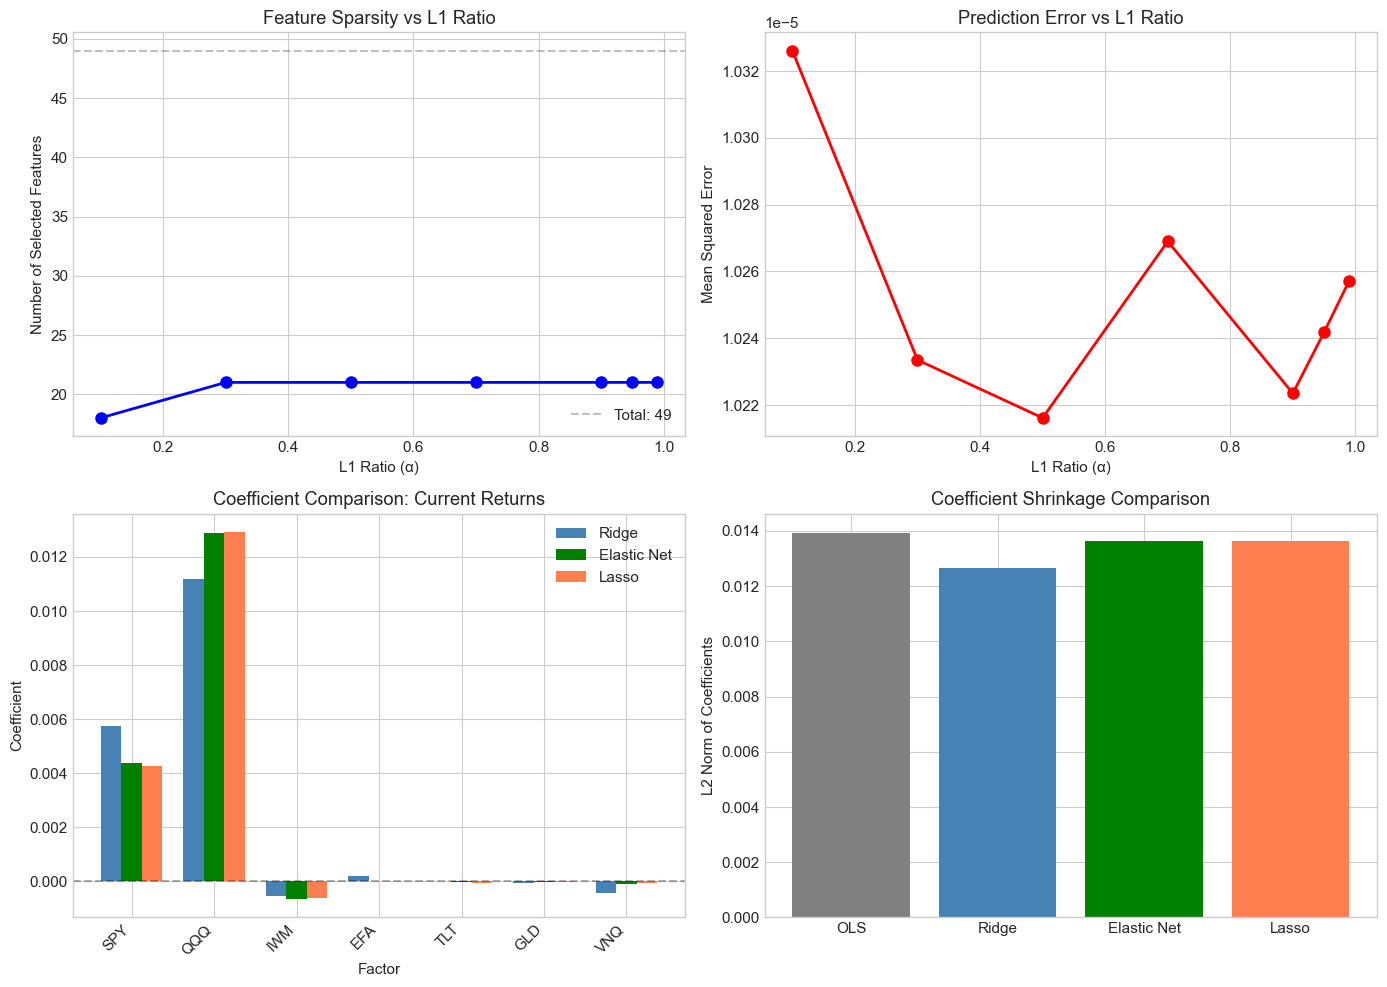

In [15]:
# Visualize Elastic Net results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Features selected vs L1 ratio
ax1 = axes[0, 0]
ax1.plot(results_df['l1_ratio'], results_df['n_features'], 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('L1 Ratio (α)')
ax1.set_ylabel('Number of Selected Features')
ax1.set_title('Feature Sparsity vs L1 Ratio')
ax1.axhline(y=len(feature_names), color='gray', linestyle='--', alpha=0.5, label=f'Total: {len(feature_names)}')
ax1.legend()

# Plot 2: MSE vs L1 ratio
ax2 = axes[0, 1]
ax2.plot(results_df['l1_ratio'], results_df['mse'], 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('L1 Ratio (α)')
ax2.set_ylabel('Mean Squared Error')
ax2.set_title('Prediction Error vs L1 Ratio')

# Plot 3: Compare coefficients - Ridge vs Lasso vs Elastic Net
ax3 = axes[1, 0]

# Get models
ridge_model = Ridge(alpha=optimal_lambda_cv)
ridge_model.fit(X_lasso_scaled, y_lasso)

lasso_model = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
lasso_model.fit(X_lasso_scaled, y_lasso)

en_model = ElasticNet(alpha=results_df.loc[results_df['l1_ratio']==0.5, 'alpha'].values[0], 
                      l1_ratio=0.5, max_iter=10000)
en_model.fit(X_lasso_scaled, y_lasso)

# Only plot first 7 (current returns) for clarity
n_show = 7
x_pos = np.arange(n_show)
width = 0.25

ax3.bar(x_pos - width, ridge_model.coef_[:n_show], width, label='Ridge', color='steelblue')
ax3.bar(x_pos, en_model.coef_[:n_show], width, label='Elastic Net', color='green')
ax3.bar(x_pos + width, lasso_model.coef_[:n_show], width, label='Lasso', color='coral')
ax3.set_xlabel('Factor')
ax3.set_ylabel('Coefficient')
ax3.set_title('Coefficient Comparison: Current Returns')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(feature_names[:n_show], rotation=45, ha='right')
ax3.legend()
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Plot 4: Coefficient magnitude comparison (L2 norm)
ax4 = axes[1, 1]
norms = {
    'OLS': np.linalg.norm(LinearRegression().fit(X_lasso_scaled, y_lasso).coef_),
    'Ridge': np.linalg.norm(ridge_model.coef_),
    'Elastic Net': np.linalg.norm(en_model.coef_),
    'Lasso': np.linalg.norm(lasso_model.coef_)
}
ax4.bar(norms.keys(), norms.values(), color=['gray', 'steelblue', 'green', 'coral'])
ax4.set_ylabel('L2 Norm of Coefficients')
ax4.set_title('Coefficient Shrinkage Comparison')

plt.tight_layout()
plt.show()

---

# Day 5: Fama-MacBeth Cross-Sectional Regression

## 5.1 The Cross-Sectional Approach

While time-series regression estimates how one asset responds to factors over time, **cross-sectional regression** estimates how factor exposures explain return differences **across assets** at each point in time.

### Two-Pass Methodology

**Pass 1: Time-Series Regression (Estimate Betas)**

For each asset $i$, run time-series regression:

$$R_{i,t} - R_{f,t} = \alpha_i + \beta_{i,1}F_{1,t} + ... + \beta_{i,K}F_{K,t} + \epsilon_{i,t}$$

This gives us $\hat{\beta}_i$ for each asset.

**Pass 2: Cross-Sectional Regression (Estimate Risk Premia)**

At each time $t$, run cross-sectional regression:

$$R_{i,t} = \gamma_{0,t} + \gamma_{1,t}\hat{\beta}_{i,1} + ... + \gamma_{K,t}\hat{\beta}_{i,K} + \eta_{i,t}$$

Average the $\gamma$ estimates over time:

$$\hat{\gamma}_k = \frac{1}{T}\sum_{t=1}^{T} \hat{\gamma}_{k,t}$$

---

## 5.2 Why Fama-MacBeth?

### Handles Panel Data Issues

1. **Cross-sectional correlation**: Asset returns are correlated at each $t$
2. **Time-varying coefficients**: Risk premia change over time
3. **Standard errors**: Fama-MacBeth provides valid standard errors

### Standard Error Calculation

$$SE(\hat{\gamma}_k) = \frac{\sigma(\hat{\gamma}_{k,t})}{\sqrt{T}}$$

Where $\sigma(\hat{\gamma}_{k,t})$ is the time-series standard deviation of the monthly $\gamma$ estimates.

**Key advantage**: This automatically accounts for cross-sectional correlation!

---

## 5.3 Financial Interpretation

- $\gamma_0$: **Zero-beta rate** (return of a portfolio with zero factor exposure)
- $\gamma_k$: **Factor risk premium** (expected return per unit of factor exposure)

If CAPM holds:
- $\gamma_0 = R_f$ (zero-beta rate equals risk-free rate)
- $\gamma_1 = E[R_m - R_f]$ (market risk premium)

---

In [16]:
# Day 5: Fama-MacBeth Cross-Sectional Regression

# Use sector ETFs as our cross-section of assets
sector_tickers = ['XLK', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU', 'XLB']
factor_ticker = 'SPY'  # Market factor

# Download data (yfinance auto_adjust=True returns 'Close')
all_tickers = sector_tickers + [factor_ticker]
sector_prices = yf.download(all_tickers, start='2015-01-01', end='2024-01-01')['Close']
sector_returns = sector_prices.pct_change().dropna()

# Convert to monthly returns for Fama-MacBeth
monthly_returns = sector_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)

print(f"Monthly data: {len(monthly_returns)} months")
print(f"Assets: {sector_tickers}")
monthly_returns.head()

[*********************100%***********************]  10 of 10 completed

Monthly data: 108 months
Assets: ['XLK', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU', 'XLB']


Ticker,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,
2015-01-31,-0.029110,-0.019733,-0.050044,-0.069551,-0.034330,-0.033196,-0.006825,0.018550,0.009325,-0.022896
2015-02-28,0.056204,0.079681,0.045930,0.058235,0.053509,0.079950,0.041441,-0.063949,0.042876,0.085441
2015-03-31,-0.015705,-0.049049,-0.011552,-0.006160,-0.025460,-0.034356,-0.019426,-0.009954,0.006406,-0.004830
2015-04-30,0.009834,0.033620,0.065739,0.000830,-0.002511,0.027510,-0.007592,-0.004726,-0.010897,-0.000531
2015-05-31,0.012856,0.003768,-0.051887,0.019478,0.003236,0.018553,0.008683,0.006332,0.045043,0.013146


In [17]:
# Pass 1: Estimate betas for each sector using rolling window
window = 36  # 3-year rolling window

# Store rolling betas
betas_df = pd.DataFrame(index=monthly_returns.index, columns=sector_tickers)

for ticker in sector_tickers:
    # Rolling regression to estimate time-varying betas
    y = monthly_returns[ticker]
    X = sm.add_constant(monthly_returns[factor_ticker])
    
    try:
        rolling_model = RollingOLS(y, X, window=window)
        rolling_results = rolling_model.fit()
        betas_df[ticker] = rolling_results.params[factor_ticker]
    except:
        # Fallback to simple rolling calculation
        for i in range(window, len(monthly_returns)):
            y_window = monthly_returns[ticker].iloc[i-window:i]
            X_window = monthly_returns[factor_ticker].iloc[i-window:i]
            model = sm.OLS(y_window, sm.add_constant(X_window)).fit()
            betas_df.loc[monthly_returns.index[i], ticker] = model.params.iloc[1]

betas_df = betas_df.dropna()
print(f"Rolling betas calculated for {len(betas_df)} months")
betas_df.tail()

Rolling betas calculated for 73 months


,XLK,XLF,XLE,XLV,XLI,XLP,XLY,XLU,XLB
Date,,,,,,,,,
2023-08-31,1.191300,1.015689,1.031659,0.667356,1.063368,0.579411,1.182715,0.599523,1.067499
2023-09-30,1.192085,1.007338,0.935737,0.667864,1.085690,0.594381,1.194623,0.633301,1.093551
2023-10-31,1.175674,1.014153,0.940600,0.666649,1.092437,0.589561,1.205549,0.648989,1.103663
2023-11-30,1.211653,0.965292,0.663126,0.653196,1.035804,0.566222,1.238569,0.711477,1.083476
2023-12-31,1.202629,0.960112,0.642594,0.654249,1.054073,0.568163,1.247744,0.712325,1.086683


In [18]:
# Pass 2: Cross-Sectional Regressions
# At each month, regress returns on lagged betas

# Align returns with lagged betas
returns_aligned = monthly_returns[sector_tickers].loc[betas_df.index]
betas_lagged = betas_df.shift(1).dropna()
returns_aligned = returns_aligned.loc[betas_lagged.index]

# Store cross-sectional gamma estimates
gamma_0 = []  # Intercepts
gamma_1 = []  # Market risk premium estimates
dates = []

for date in betas_lagged.index:
    # Get returns and betas for this month
    y_cs = returns_aligned.loc[date].values
    X_cs = betas_lagged.loc[date].values.astype(float)
    
    # Skip if any NaN
    if np.any(np.isnan(y_cs)) or np.any(np.isnan(X_cs)):
        continue
    
    # Cross-sectional regression
    X_cs_const = sm.add_constant(X_cs)
    model_cs = sm.OLS(y_cs, X_cs_const).fit()
    
    gamma_0.append(model_cs.params[0])
    gamma_1.append(model_cs.params[1])
    dates.append(date)

# Convert to arrays
gamma_0 = np.array(gamma_0)
gamma_1 = np.array(gamma_1)

print(f"Cross-sectional regressions: {len(gamma_1)} months")

Cross-sectional regressions: 72 months


In [19]:
# Fama-MacBeth Risk Premium Estimates
print("=" * 60)
print("FAMA-MACBETH REGRESSION RESULTS")
print("=" * 60)

# Calculate means and standard errors
gamma_0_mean = np.mean(gamma_0)
gamma_0_se = np.std(gamma_0) / np.sqrt(len(gamma_0))
gamma_0_t = gamma_0_mean / gamma_0_se

gamma_1_mean = np.mean(gamma_1)
gamma_1_se = np.std(gamma_1) / np.sqrt(len(gamma_1))
gamma_1_t = gamma_1_mean / gamma_1_se

print(f"\n{'Parameter':<20} {'Estimate':<12} {'Std Error':<12} {'t-stat':<10} {'Annualized':<12}")
print("-" * 66)
print(f"{'γ₀ (Zero-Beta)':<20} {gamma_0_mean:>11.4f} {gamma_0_se:>11.4f} {gamma_0_t:>9.2f} {gamma_0_mean*12:>11.2%}")
print(f"{'γ₁ (Market Premium)':<20} {gamma_1_mean:>11.4f} {gamma_1_se:>11.4f} {gamma_1_t:>9.2f} {gamma_1_mean*12:>11.2%}")

print(f"\n\nInterpretation:")
print(f"  - Zero-beta return: {gamma_0_mean*12:.2%} per year")
print(f"  - Market risk premium: {gamma_1_mean*12:.2%} per year per unit of beta")
print(f"  - Market premium significant: {'Yes' if abs(gamma_1_t) > 1.96 else 'No'} (t={gamma_1_t:.2f})")

FAMA-MACBETH REGRESSION RESULTS

Parameter            Estimate     Std Error    t-stat     Annualized  
------------------------------------------------------------------
γ₀ (Zero-Beta)            0.0007      0.0072      0.10       0.86%
γ₁ (Market Premium)       0.0093      0.0088      1.06      11.20%


Interpretation:
  - Zero-beta return: 0.86% per year
  - Market risk premium: 11.20% per year per unit of beta
  - Market premium significant: No (t=1.06)


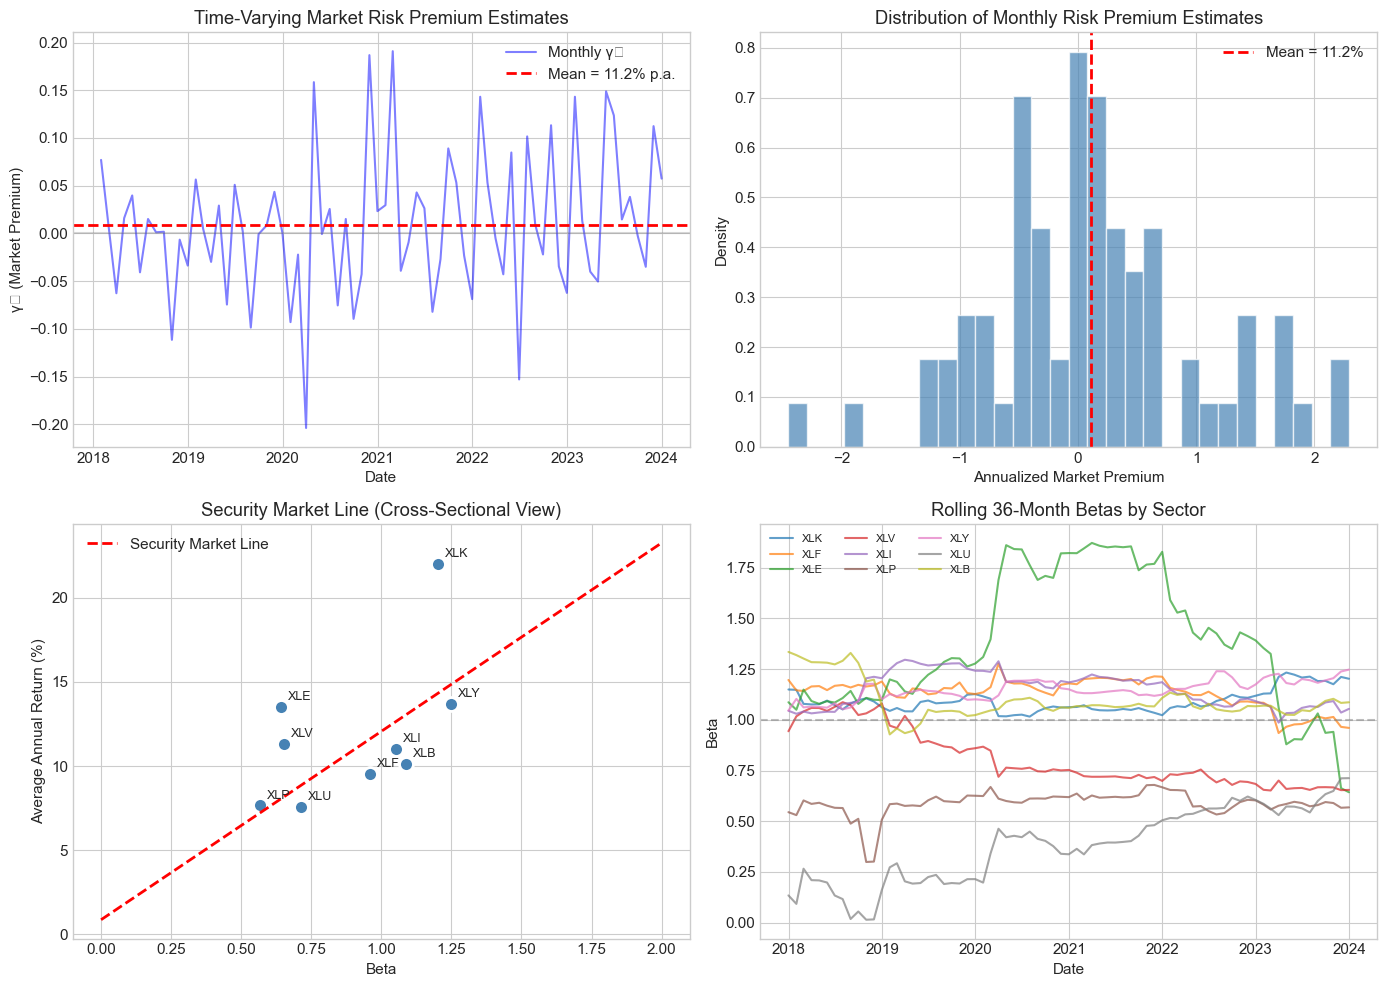

In [20]:
# Visualize Fama-MacBeth Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Time series of gamma estimates
ax1 = axes[0, 0]
ax1.plot(dates, gamma_1, 'b-', alpha=0.5, label='Monthly γ₁')
ax1.axhline(y=gamma_1_mean, color='r', linestyle='--', linewidth=2, 
            label=f'Mean = {gamma_1_mean*12:.1%} p.a.')
ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax1.set_xlabel('Date')
ax1.set_ylabel('γ₁ (Market Premium)')
ax1.set_title('Time-Varying Market Risk Premium Estimates')
ax1.legend()

# Plot 2: Distribution of gamma estimates
ax2 = axes[0, 1]
ax2.hist(gamma_1 * 12, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='white')
ax2.axvline(x=gamma_1_mean * 12, color='r', linestyle='--', linewidth=2, 
            label=f'Mean = {gamma_1_mean*12:.1%}')
ax2.set_xlabel('Annualized Market Premium')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of Monthly Risk Premium Estimates')
ax2.legend()

# Plot 3: Security Market Line (final month)
ax3 = axes[1, 0]
final_betas = betas_df.iloc[-1].values.astype(float)
avg_returns = returns_aligned.mean() * 12  # Annualized

ax3.scatter(final_betas, avg_returns.values * 100, s=100, c='steelblue', edgecolor='white', linewidth=2)
for i, ticker in enumerate(sector_tickers):
    ax3.annotate(ticker, (final_betas[i], avg_returns.values[i] * 100), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Plot SML
beta_range = np.linspace(0, 2, 100)
sml = (gamma_0_mean + gamma_1_mean * beta_range) * 12 * 100
ax3.plot(beta_range, sml, 'r--', linewidth=2, label='Security Market Line')
ax3.set_xlabel('Beta')
ax3.set_ylabel('Average Annual Return (%)')
ax3.set_title('Security Market Line (Cross-Sectional View)')
ax3.legend()

# Plot 4: Rolling betas over time
ax4 = axes[1, 1]
for ticker in sector_tickers:
    ax4.plot(betas_df.index, betas_df[ticker], label=ticker, alpha=0.7)
ax4.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax4.set_xlabel('Date')
ax4.set_ylabel('Beta')
ax4.set_title('Rolling 36-Month Betas by Sector')
ax4.legend(loc='upper left', ncol=3, fontsize=8)

plt.tight_layout()
plt.show()

---

# Day 6: WLS and Robust Regression

## 6.1 Heteroskedasticity in Finance

Financial returns are almost always **heteroskedastic** - variance changes over time:
- Volatility clustering (GARCH effects)
- Higher volatility during market stress
- Different volatility across assets

When $Var(\epsilon_i) = \sigma_i^2 \neq \sigma^2$:
- OLS estimates are still **unbiased**
- But standard errors are **wrong** (usually too small)
- OLS is no longer **efficient** (not minimum variance)

---

## 6.2 Weighted Least Squares (WLS)

### Formulation

If $Var(\epsilon) = \Omega$ (non-scalar covariance matrix), the GLS estimator is:

$$\hat{\beta}_{GLS} = (X'\Omega^{-1}X)^{-1}X'\Omega^{-1}Y$$

For **WLS** (diagonal $\Omega$), with weights $w_i = 1/\sigma_i^2$:

$$\hat{\beta}_{WLS} = \arg\min_{\beta} \sum_{i=1}^{n} w_i(y_i - x_i'\beta)^2$$

### Intuition

- Observations with lower variance get **higher weights**
- High-volatility observations contribute less to the fit
- Makes regression more stable across different volatility regimes

### Common Weight Specifications in Finance

1. **Inverse variance**: $w_i = 1/\hat{\sigma}_i^2$ (from GARCH)
2. **Inverse squared return**: $w_i = 1/r_i^2$ (simple approximation)
3. **Time decay**: $w_i = \lambda^{T-t}$ (exponential decay)

---

## 6.3 Robust Standard Errors (White/Newey-West)

### Heteroskedasticity-Consistent (White) Standard Errors

Instead of transforming the regression, adjust the standard errors:

$$\widehat{Var}(\hat{\beta}) = (X'X)^{-1} \left( \sum_{i=1}^{n} \hat{\epsilon}_i^2 x_i x_i' \right) (X'X)^{-1}$$

This is the **sandwich estimator** - valid under heteroskedasticity.

### HAC (Newey-West) Standard Errors

Also accounts for autocorrelation:

$$\widehat{Var}_{HAC}(\hat{\beta}) = (X'X)^{-1} \hat{\Sigma}_{HAC} (X'X)^{-1}$$

Where $\hat{\Sigma}_{HAC}$ includes autocovariance terms up to lag $L$.

---

## 6.4 Robust Regression (M-Estimation)

When outliers are present, OLS can be severely affected. Robust regression uses different loss functions:

| Method | Loss Function | Property |
|--------|--------------|----------|
| OLS | $\rho(r) = r^2$ | Sensitive to outliers |
| Huber | $\rho(r) = r^2$ if $|r| \leq k$, else $2k|r| - k^2$ | Bounded influence |
| Bisquare | $\rho(r) = 1 - (1 - (r/k)^2)^3$ if $|r| \leq k$, else 1 | Downweights outliers |

---

In [21]:
# Day 6: WLS and Robust Regression

# Prepare data - CAPM regression with heteroskedasticity
market_ret = returns['SPY'].values
asset_ret = returns['XLE'].values  # Energy sector - highly volatile

# Calculate rolling volatility for weights
rolling_vol = returns['XLE'].rolling(20).std().dropna()
start_idx = len(returns) - len(rolling_vol)

market_ret_wls = market_ret[start_idx:]
asset_ret_wls = asset_ret[start_idx:]
weights = 1 / (rolling_vol.values ** 2)  # Inverse variance weights
weights = weights / weights.mean()  # Normalize

print(f"Data points: {len(asset_ret_wls)}")
print(f"Weight range: {weights.min():.2f} to {weights.max():.2f}")

Data points: 1489
Weight range: 0.02 to 5.93


In [22]:
# Compare OLS, WLS, and Robust regression
X_reg = sm.add_constant(market_ret_wls)

# 1. OLS with regular standard errors
model_ols = sm.OLS(asset_ret_wls, X_reg).fit()

# 2. OLS with White (heteroskedasticity-robust) standard errors
model_hc = sm.OLS(asset_ret_wls, X_reg).fit(cov_type='HC1')

# 3. OLS with Newey-West (HAC) standard errors
model_hac = sm.OLS(asset_ret_wls, X_reg).fit(cov_type='HAC', cov_kwds={'maxlags': 5})

# 4. WLS with inverse volatility weights
model_wls = sm.WLS(asset_ret_wls, X_reg, weights=weights).fit()

# 5. Robust regression (Huber)
from statsmodels.robust.robust_linear_model import RLM
model_robust = RLM(asset_ret_wls, X_reg, M=sm.robust.norms.HuberT()).fit()

print("=" * 80)
print("REGRESSION COMPARISON: XLE ~ SPY")
print("=" * 80)
print(f"\n{'Model':<25} {'Alpha':<12} {'SE(α)':<10} {'Beta':<12} {'SE(β)':<10} {'R²':<8}")
print("-" * 77)
print(f"{'OLS (Standard)':<25} {model_ols.params[0]:>11.6f} {model_ols.bse[0]:>9.6f} {model_ols.params[1]:>11.4f} {model_ols.bse[1]:>9.4f} {model_ols.rsquared:>7.4f}")
print(f"{'OLS (White HC1)':<25} {model_hc.params[0]:>11.6f} {model_hc.bse[0]:>9.6f} {model_hc.params[1]:>11.4f} {model_hc.bse[1]:>9.4f} {model_hc.rsquared:>7.4f}")
print(f"{'OLS (Newey-West)':<25} {model_hac.params[0]:>11.6f} {model_hac.bse[0]:>9.6f} {model_hac.params[1]:>11.4f} {model_hac.bse[1]:>9.4f} {model_hac.rsquared:>7.4f}")
print(f"{'WLS (Inv. Volatility)':<25} {model_wls.params[0]:>11.6f} {model_wls.bse[0]:>9.6f} {model_wls.params[1]:>11.4f} {model_wls.bse[1]:>9.4f} {model_wls.rsquared:>7.4f}")
print(f"{'Robust (Huber)':<25} {model_robust.params[0]:>11.6f} {model_robust.bse[0]:>9.6f} {model_robust.params[1]:>11.4f} {model_robust.bse[1]:>9.4f} {'N/A':>7}")

REGRESSION COMPARISON: XLE ~ SPY

Model                     Alpha        SE(α)      Beta         SE(β)      R²      
-----------------------------------------------------------------------------
OLS (Standard)              -0.000029  0.000440      1.0684    0.0341  0.3977
OLS (White HC1)             -0.000029  0.000443      1.0684    0.0626  0.3977
OLS (Newey-West)            -0.000029  0.000455      1.0684    0.0659  0.3977
WLS (Inv. Volatility)       -0.000303  0.000320      0.8507    0.0351  0.2832
Robust (Huber)              -0.000378  0.000382      0.9847    0.0296     N/A


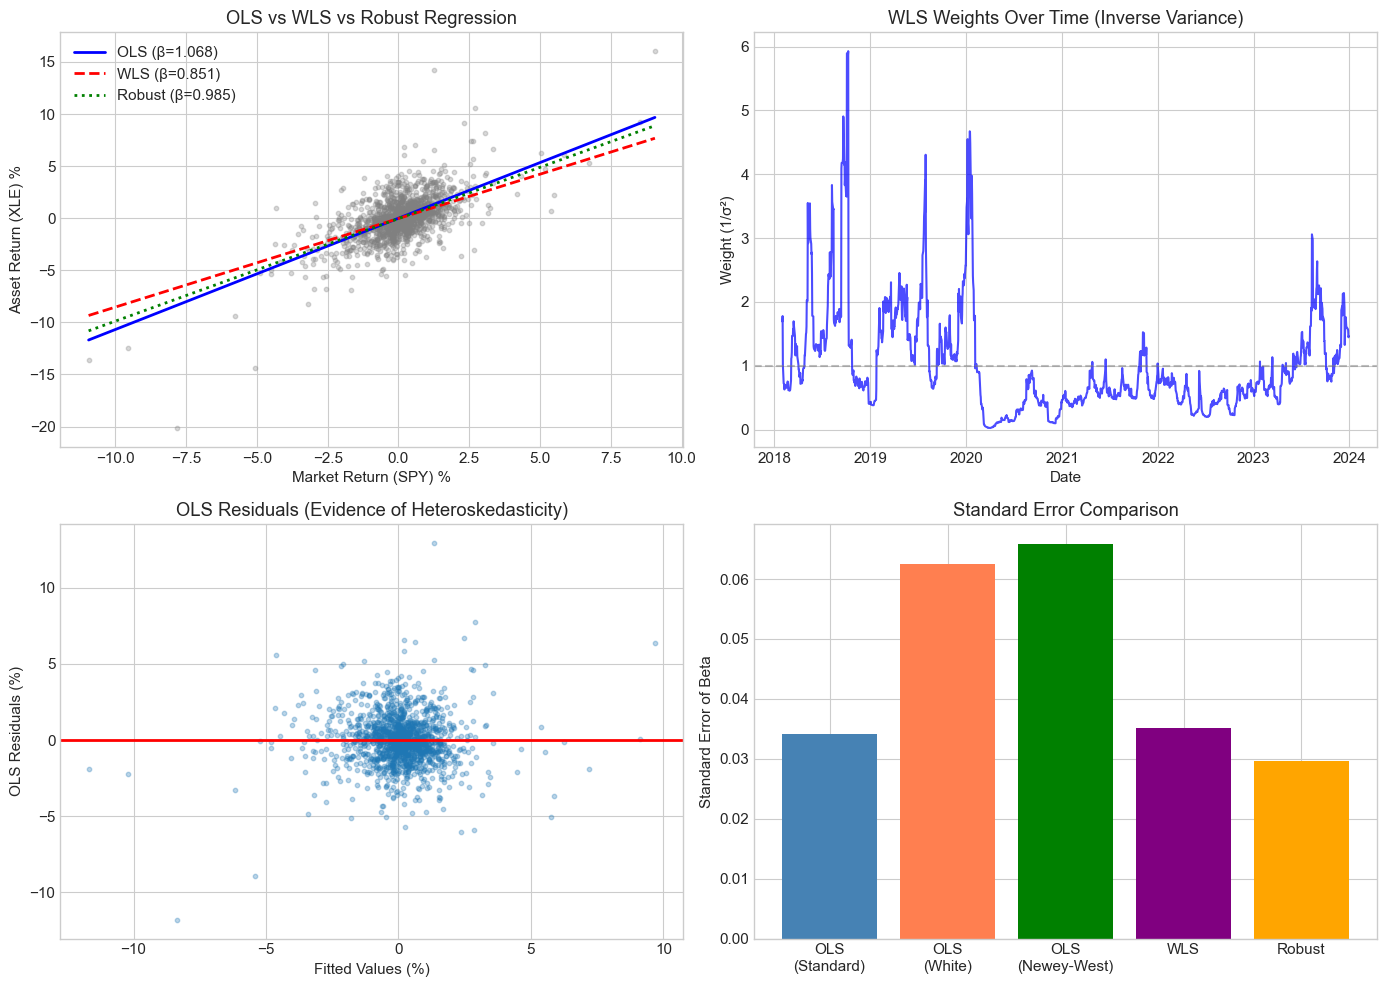

In [23]:
# Visualize heteroskedasticity and model fits
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Scatter with OLS vs WLS fits
ax1 = axes[0, 0]
ax1.scatter(market_ret_wls * 100, asset_ret_wls * 100, alpha=0.3, s=10, c='gray')

x_line = np.linspace(market_ret_wls.min(), market_ret_wls.max(), 100)
ax1.plot(x_line * 100, (model_ols.params[0] + model_ols.params[1] * x_line) * 100, 
         'b-', linewidth=2, label=f'OLS (β={model_ols.params[1]:.3f})')
ax1.plot(x_line * 100, (model_wls.params[0] + model_wls.params[1] * x_line) * 100, 
         'r--', linewidth=2, label=f'WLS (β={model_wls.params[1]:.3f})')
ax1.plot(x_line * 100, (model_robust.params[0] + model_robust.params[1] * x_line) * 100, 
         'g:', linewidth=2, label=f'Robust (β={model_robust.params[1]:.3f})')
ax1.set_xlabel('Market Return (SPY) %')
ax1.set_ylabel('Asset Return (XLE) %')
ax1.set_title('OLS vs WLS vs Robust Regression')
ax1.legend()

# Plot 2: WLS weights over time
ax2 = axes[0, 1]
ax2.plot(rolling_vol.index, weights, 'b-', alpha=0.7)
ax2.set_xlabel('Date')
ax2.set_ylabel('Weight (1/σ²)')
ax2.set_title('WLS Weights Over Time (Inverse Variance)')
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5)

# Plot 3: Residuals vs fitted (heteroskedasticity check)
ax3 = axes[1, 0]
residuals_ols = model_ols.resid
ax3.scatter(model_ols.fittedvalues * 100, residuals_ols * 100, alpha=0.3, s=10)
ax3.axhline(y=0, color='r', linestyle='-', linewidth=2)
ax3.set_xlabel('Fitted Values (%)')
ax3.set_ylabel('OLS Residuals (%)')
ax3.set_title('OLS Residuals (Evidence of Heteroskedasticity)')

# Plot 4: Standard error comparison
ax4 = axes[1, 1]
models = ['OLS\n(Standard)', 'OLS\n(White)', 'OLS\n(Newey-West)', 'WLS', 'Robust']
se_beta = [model_ols.bse[1], model_hc.bse[1], model_hac.bse[1], model_wls.bse[1], model_robust.bse[1]]
colors = ['steelblue', 'coral', 'green', 'purple', 'orange']
ax4.bar(models, se_beta, color=colors)
ax4.set_ylabel('Standard Error of Beta')
ax4.set_title('Standard Error Comparison')
ax4.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [24]:
# Demonstrate impact of outliers on different methods

# Add synthetic outliers to demonstrate robust regression
np.random.seed(42)
n_outliers = 10
outlier_idx = np.random.choice(len(market_ret_wls), n_outliers, replace=False)

asset_ret_outliers = asset_ret_wls.copy()
asset_ret_outliers[outlier_idx] = asset_ret_outliers[outlier_idx] * 5  # Amplify outliers

# Fit models with outliers
model_ols_out = sm.OLS(asset_ret_outliers, X_reg).fit()
model_robust_out = RLM(asset_ret_outliers, X_reg, M=sm.robust.norms.HuberT()).fit()

print("\n" + "=" * 60)
print("IMPACT OF OUTLIERS")
print("=" * 60)
print(f"\nOriginal Data:")
print(f"  OLS Beta: {model_ols.params[1]:.4f}")
print(f"  Robust Beta: {model_robust.params[1]:.4f}")
print(f"\nWith {n_outliers} Amplified Outliers:")
print(f"  OLS Beta: {model_ols_out.params[1]:.4f} (change: {model_ols_out.params[1] - model_ols.params[1]:+.4f})")
print(f"  Robust Beta: {model_robust_out.params[1]:.4f} (change: {model_robust_out.params[1] - model_robust.params[1]:+.4f})")
print(f"\n→ Robust regression is {abs(model_ols_out.params[1] - model_ols.params[1])/abs(model_robust_out.params[1] - model_robust.params[1]):.1f}x more stable")


IMPACT OF OUTLIERS

Original Data:
  OLS Beta: 1.0684
  Robust Beta: 0.9847

With 10 Amplified Outliers:
  OLS Beta: 1.0753 (change: +0.0068)
  Robust Beta: 0.9906 (change: +0.0058)

→ Robust regression is 1.2x more stable


---

# Day 7: Interview Review & Key Takeaways

## 7.1 Summary: When to Use Each Method

| Scenario | Recommended Method | Reason |
|----------|-------------------|--------|
| Simple factor regression | OLS | Baseline, interpretable |
| Multicollinear factors | Ridge | Stabilizes coefficients |
| Many candidate factors | Lasso | Automatic selection |
| Correlated factors + sparsity | Elastic Net | Grouped selection |
| Cross-sectional asset pricing | Fama-MacBeth | Handles correlation |
| Changing volatility | WLS | Efficient estimation |
| Potential outliers | Robust regression | Bounded influence |
| Serial correlation | Newey-West SE | Valid inference |

---

## 7.2 Common Interview Questions

### Q1: What are the Gauss-Markov assumptions?

**Answer**: The five assumptions for OLS to be BLUE:
1. Linearity in parameters
2. Random sampling / Full rank of X
3. Zero conditional mean of errors (exogeneity)
4. Homoskedasticity (constant error variance)
5. No autocorrelation

If (4) or (5) fail → OLS is still unbiased but inefficient, use robust SE or WLS.

### Q2: Explain the bias-variance tradeoff

**Answer**: 
- **Bias**: Error from wrong model assumptions (underfitting)
- **Variance**: Error from sensitivity to training data (overfitting)
- **Tradeoff**: Reducing one typically increases the other
- **Regularization**: Intentionally adds bias to reduce variance

### Q3: When would you use Lasso vs Ridge?

**Answer**:
- **Lasso**: When you believe only a subset of features are relevant (sparse model). Good for feature selection.
- **Ridge**: When most features are relevant but potentially correlated. Never sets coefficients exactly to zero.
- **Elastic Net**: When features are correlated AND you want sparsity.

### Q4: What is the Fama-MacBeth procedure?

**Answer**: A two-pass methodology to estimate factor risk premia:
1. **Time-series pass**: Estimate factor betas for each asset
2. **Cross-sectional pass**: At each time, regress returns on betas
3. **Average**: Take time-series average of cross-sectional coefficients

Advantage: Standard errors automatically account for cross-sectional correlation.

### Q5: How do you handle heteroskedasticity?

**Answer**: Several approaches:
1. **Robust SE (White)**: Adjust standard errors, keep OLS estimates
2. **HAC SE (Newey-West)**: Also handles autocorrelation
3. **WLS**: Weight observations by inverse variance
4. **GARCH**: Model time-varying volatility explicitly

---

## 7.3 Mathematical Formulas Summary

### Estimators

$$\hat{\beta}_{OLS} = (X'X)^{-1}X'Y$$

$$\hat{\beta}_{Ridge} = (X'X + \lambda I)^{-1}X'Y$$

$$\hat{\beta}_{Lasso} = \arg\min_\beta \left\{ ||Y - X\beta||_2^2 + \lambda||\beta||_1 \right\}$$

$$\hat{\beta}_{EN} = \arg\min_\beta \left\{ ||Y - X\beta||_2^2 + \lambda\alpha||\beta||_1 + \frac{\lambda(1-\alpha)}{2}||\beta||_2^2 \right\}$$

$$\hat{\beta}_{WLS} = (X'WX)^{-1}X'WY$$

### CAPM

$$E[R_i] - R_f = \beta_i(E[R_m] - R_f)$$

$$\beta_i = \frac{Cov(R_i, R_m)}{Var(R_m)}$$

---

In [25]:
# Final Summary: Model Performance Comparison

# Use the same data for fair comparison
X_final = X_lasso_scaled
y_final = y_lasso

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

models = {
    'OLS': LinearRegression(),
    'Ridge': Ridge(alpha=optimal_lambda_cv),
    'Lasso': Lasso(alpha=lasso_cv.alpha_, max_iter=10000),
    'Elastic Net': ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000)
}

results = []
for name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_final, y_final, cv=tscv, scoring='neg_mean_squared_error')
    
    # Fit full model for coefficient count
    model.fit(X_final, y_final)
    n_coef = np.sum(model.coef_ != 0)
    
    results.append({
        'Model': name,
        'CV MSE': -cv_scores.mean(),
        'CV MSE Std': cv_scores.std(),
        'Non-zero Coef': n_coef,
        'Coef Norm': np.linalg.norm(model.coef_)
    })

results_df = pd.DataFrame(results)
print("=" * 70)
print("FINAL MODEL COMPARISON (Time Series CV)")
print("=" * 70)
print(results_df.to_string(index=False))

FINAL MODEL COMPARISON (Time Series CV)
      Model   CV MSE  CV MSE Std  Non-zero Coef  Coef Norm
        OLS 0.000014    0.000005             49   0.013930
      Ridge 0.000017    0.000009             49   0.012659
      Lasso 0.000012    0.000004             21   0.013638
Elastic Net 0.000013    0.000006              2   0.013353


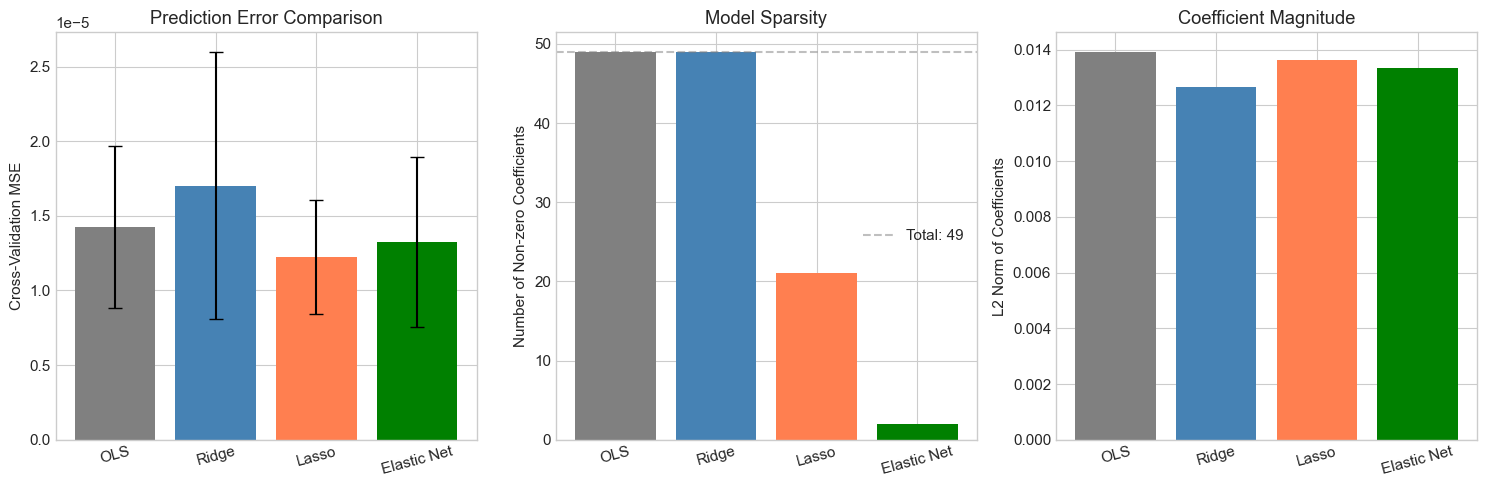


WEEK 5.1 COMPLETE: Linear Models for Finance


In [26]:
# Visualization: Final comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: CV MSE Comparison
ax1 = axes[0]
colors = ['gray', 'steelblue', 'coral', 'green']
bars = ax1.bar(results_df['Model'], results_df['CV MSE'], color=colors, 
               yerr=results_df['CV MSE Std'], capsize=5)
ax1.set_ylabel('Cross-Validation MSE')
ax1.set_title('Prediction Error Comparison')
ax1.tick_params(axis='x', rotation=15)

# Plot 2: Number of Features
ax2 = axes[1]
ax2.bar(results_df['Model'], results_df['Non-zero Coef'], color=colors)
ax2.axhline(y=len(feature_names), color='gray', linestyle='--', alpha=0.5, label=f'Total: {len(feature_names)}')
ax2.set_ylabel('Number of Non-zero Coefficients')
ax2.set_title('Model Sparsity')
ax2.tick_params(axis='x', rotation=15)
ax2.legend()

# Plot 3: Coefficient Shrinkage
ax3 = axes[2]
ax3.bar(results_df['Model'], results_df['Coef Norm'], color=colors)
ax3.set_ylabel('L2 Norm of Coefficients')
ax3.set_title('Coefficient Magnitude')
ax3.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("WEEK 5.1 COMPLETE: Linear Models for Finance")
print("="*60)